In [1]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import ndimage
from scipy.optimize import leastsq, minimize
from colormap import rgb2hex

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score
sys.path.append('../src/inference')
from utils import *

import tensorflow as tf

data_dir = '../data/img'
model_dir = '../model'
img_size_grid = (512,512)
img_size_digit = (28,28)

In [2]:
def load_model(path):
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    return interpreter
    
def inference_grid(interpreter, img):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(np.expand_dims(img,axis=0), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    return np.squeeze(np.rint(output_data))

def inference_digit(interpreter, img):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(np.expand_dims(img.reshape(28,28,1), axis=0), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    idx = np.argmax(output_data, axis=-1)[0]
    return  idx + 1, output_data[0][idx]

def process_output(p):
    label, _ = ndimage.label(p, np.ones((3,3)))
    m = Counter(label.flatten()).most_common(2)[1][0]
    p = np.where(label==m, 1, 0)
    return p

# TFLite models

In [3]:
digit = load_model(os.path.join(model_dir, 'digit_classifier.tflite'))
grid = load_model(os.path.join(model_dir, 'grid_detection.tflite'))

# Load data

In [4]:
list_path = []
accepted = ['.png', '.jpeg', '.jpg']

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if os.path.splitext(file)[1].lower() in accepted:
            list_path.append(os.path.join(root, file))

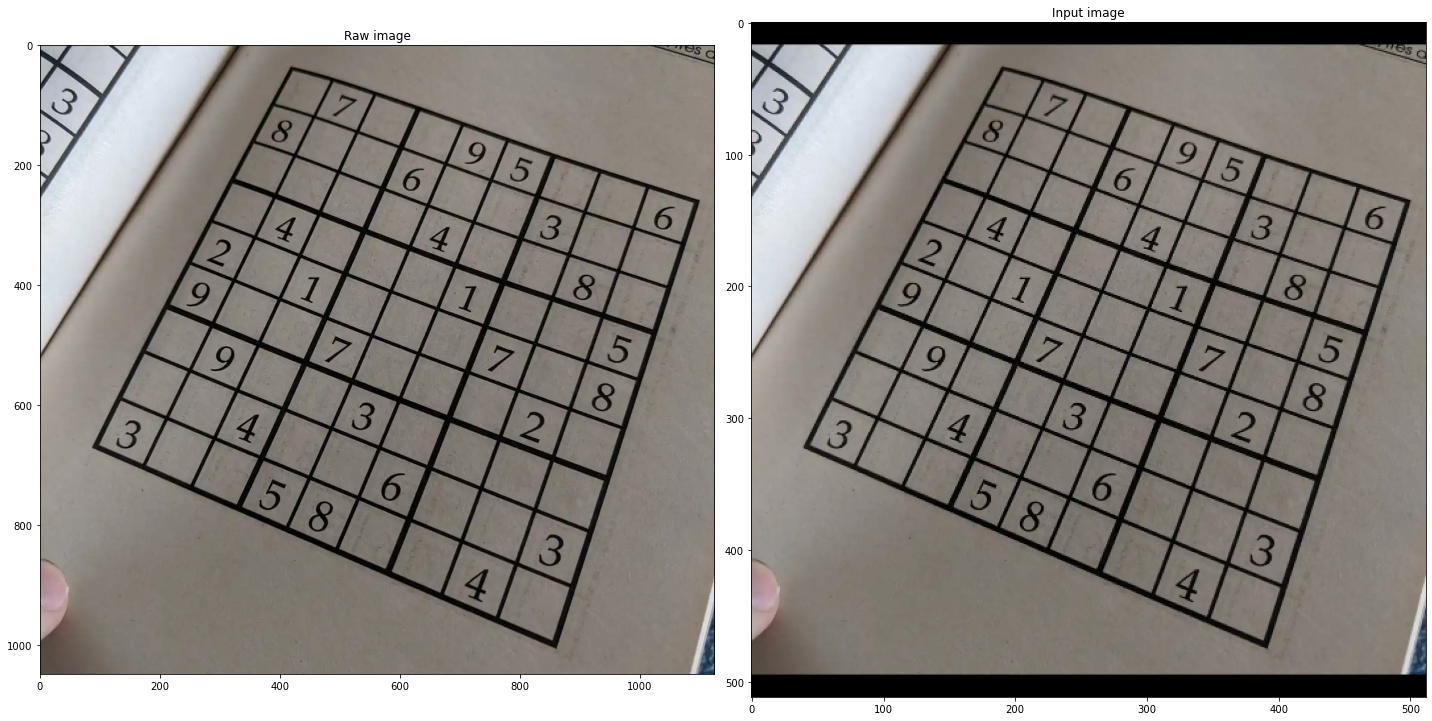

In [5]:
idx = 0
img = cv2.imread(list_path[idx])[:,:,[2,1,0]]
img_in = pad_resize_img(img, img_size_grid)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Raw image')
plt.subplot(1,2,2)
plt.imshow(img_in)
plt.title('Input image')

plt.tight_layout()
plt.show()

# Inference

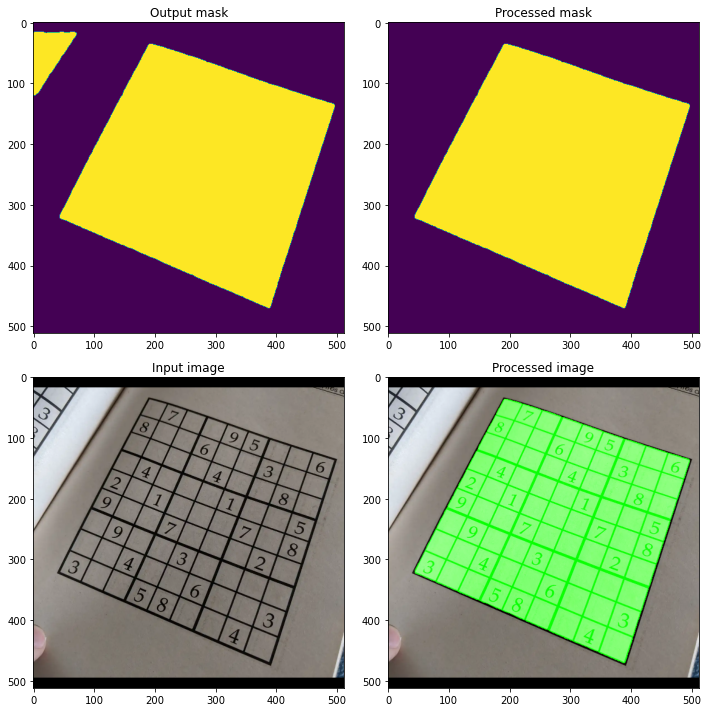

In [6]:
pred = inference_grid(grid, img_in)
mask = process_output(pred)

fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(pred)
plt.title('Output mask')
plt.subplot(2,2,2)
plt.imshow(mask)
plt.title('Processed mask')
plt.subplot(2,2,3)
plt.imshow(img_in)
plt.title('Input image')
plt.subplot(2,2,4)
green = np.zeros(img_in.shape)
green[mask.astype(bool)] = [0,255,0]
res = cv2.bitwise_or(img_in.astype(np.uint8), green.astype(np.uint8))
plt.imshow(res)
plt.title('Processed image')

plt.tight_layout()
plt.show()

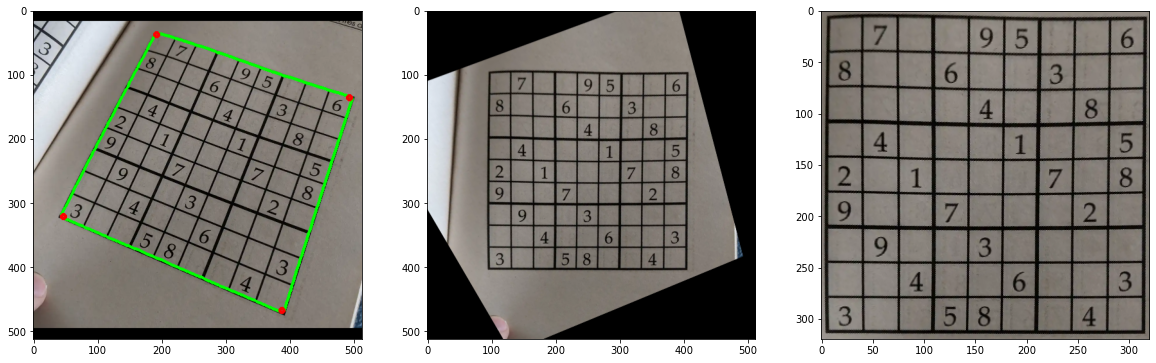

In [7]:
(vis, warp, warp_box), corner_warp = find_corners_harris(img_in, mask)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(vis)
plt.subplot(1,3,2)
plt.imshow(warp)
plt.subplot(1,3,3)
plt.imshow(warp_box)

plt.show()

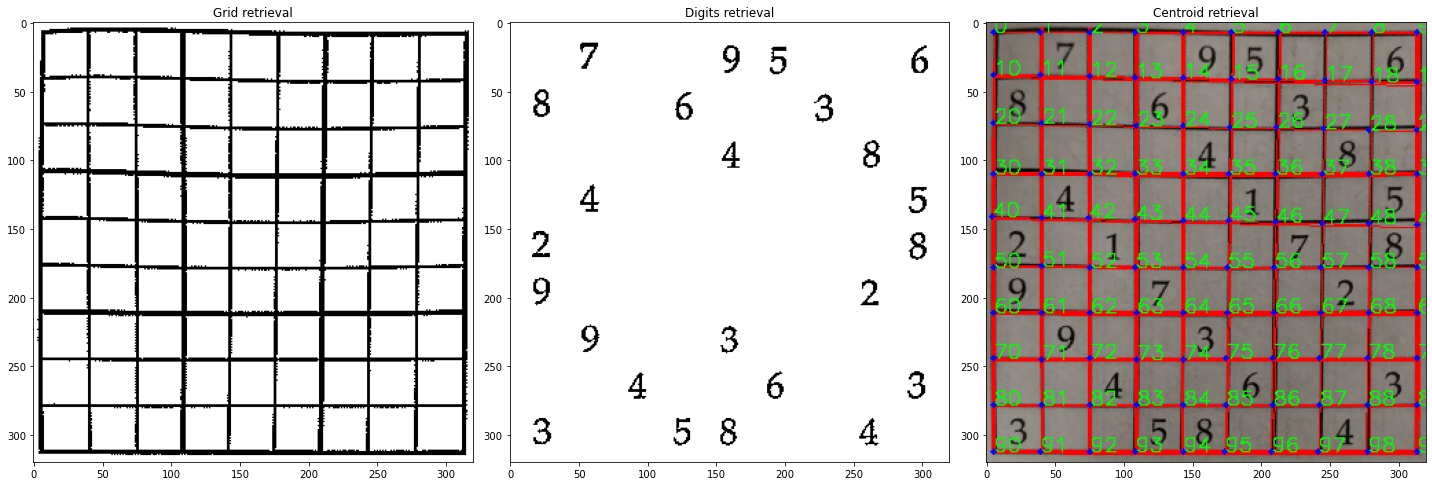

In [8]:
centroid, (grid_vis, digit_vis), bbox, X, vis = analyse_img(warp_box)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(grid_vis)
plt.title('Grid retrieval')
plt.subplot(1,3,2)
plt.imshow(digit_vis)
plt.title('Digits retrieval')
plt.subplot(1,3,3)
plt.imshow(vis)
plt.title('Centroid retrieval')

plt.tight_layout()
plt.show()

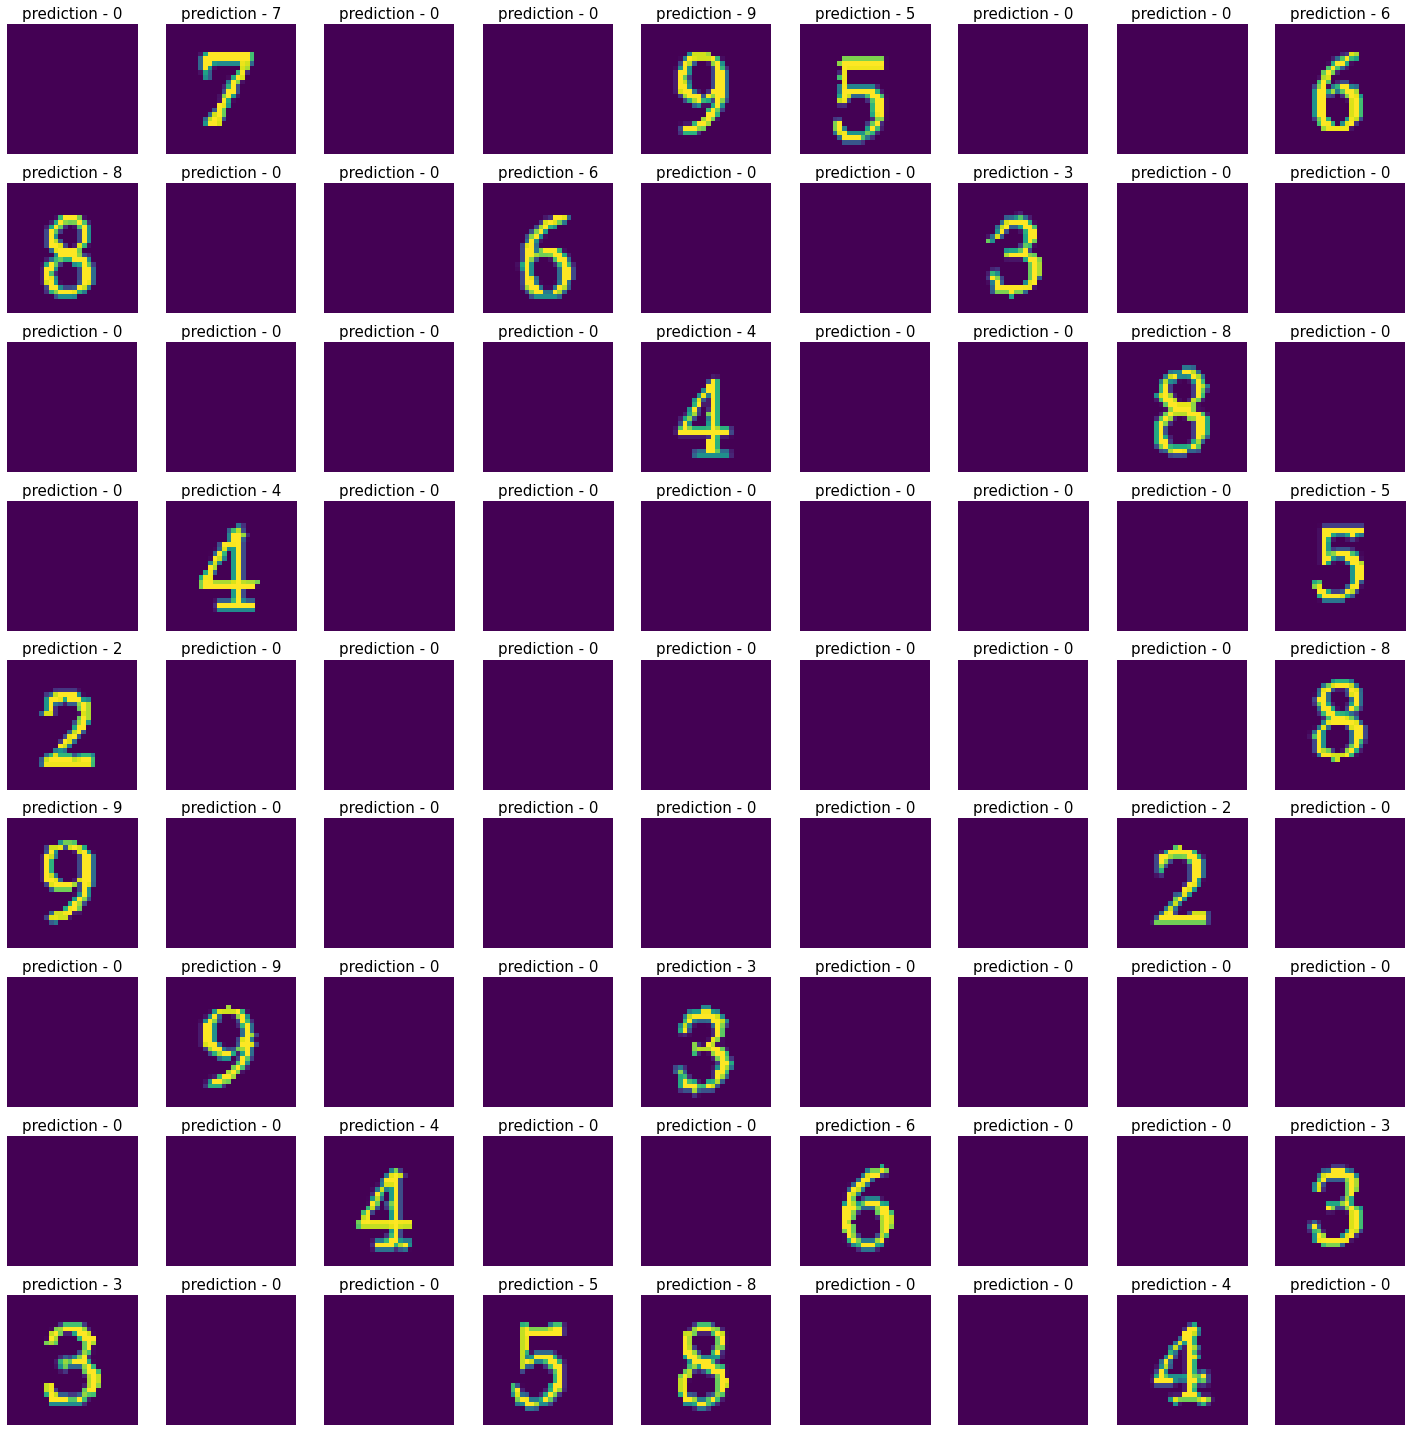

In [82]:
plt.figure(figsize=(20,20))
grid_solve = np.empty((81)).astype(int)
img_tile = np.zeros((81, *img_size_digit))

for idx, box in enumerate(bbox):
    offset = 0
    x0, x1, y0, y1 = box
    roi = digit_vis[y0+offset:y1-offset,x0+offset:x1-offset]
    gray = cv2.cvtColor(np.invert(roi), cv2.COLOR_RGB2GRAY)
    gray = cv2.normalize(gray, np.zeros(gray.shape), 0, 255, cv2.NORM_MINMAX)
    img_resize = pad_resize_gray(gray, (28,28))
    
    pred, confidence = inference_digit(digit, img_resize)
    l = pred if np.sum(gray)>100 else 0
    
    plt.subplot(9,9,idx+1)
    plt.imshow(img_resize)
    plt.axis('off')
    plt.title(f'prediction - {l}',fontsize=15)
    
    grid_solve[idx] = l
    img_tile[idx,:,:] = img_resize
    
grid_solve = grid_solve.reshape(9,9)
zeros = np.where(grid_solve==0, True, False)

plt.tight_layout()

In [84]:
def isSafe(grid, row, col, num):
    for x in range(9):
        if grid[row][x] == num:
            return False
    for x in range(9):
        if grid[x][col] == num:
            return False
    startRow = row - row % 3
    startCol = col - col % 3
    for i in range(3):
        for j in range(3):
            if grid[i + startRow][j + startCol] == num:
                return False
    return True

def solveSudoku(grid, row, col):
    if (row == 9 - 1 and col == 9):
        return True
    if col == 9:
        row += 1
        col = 0
    if grid[row][col] > 0:
        return solveSudoku(grid, row, col + 1)
    for num in range(1, N + 1, 1):
        if isSafe(grid, row, col, num):
            grid[row][col] = num
            if solveSudoku(grid, row, col + 1):
                return True
        grid[row][col] = 0
    return False
 
solveSudoku(grid_solve, 0, 0)
solution = grid_solve.copy()
solution[~zeros] = 0

In [85]:
def num_on_img(l):
    img_solution = np.zeros((28,28,3))
    img_solution = cv2.putText(img_solution, f'{l}', (5,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255), 1, cv2.LINE_AA)
    return cv2.cvtColor(img_solution.astype(np.uint8), cv2.COLOR_RGB2GRAY)

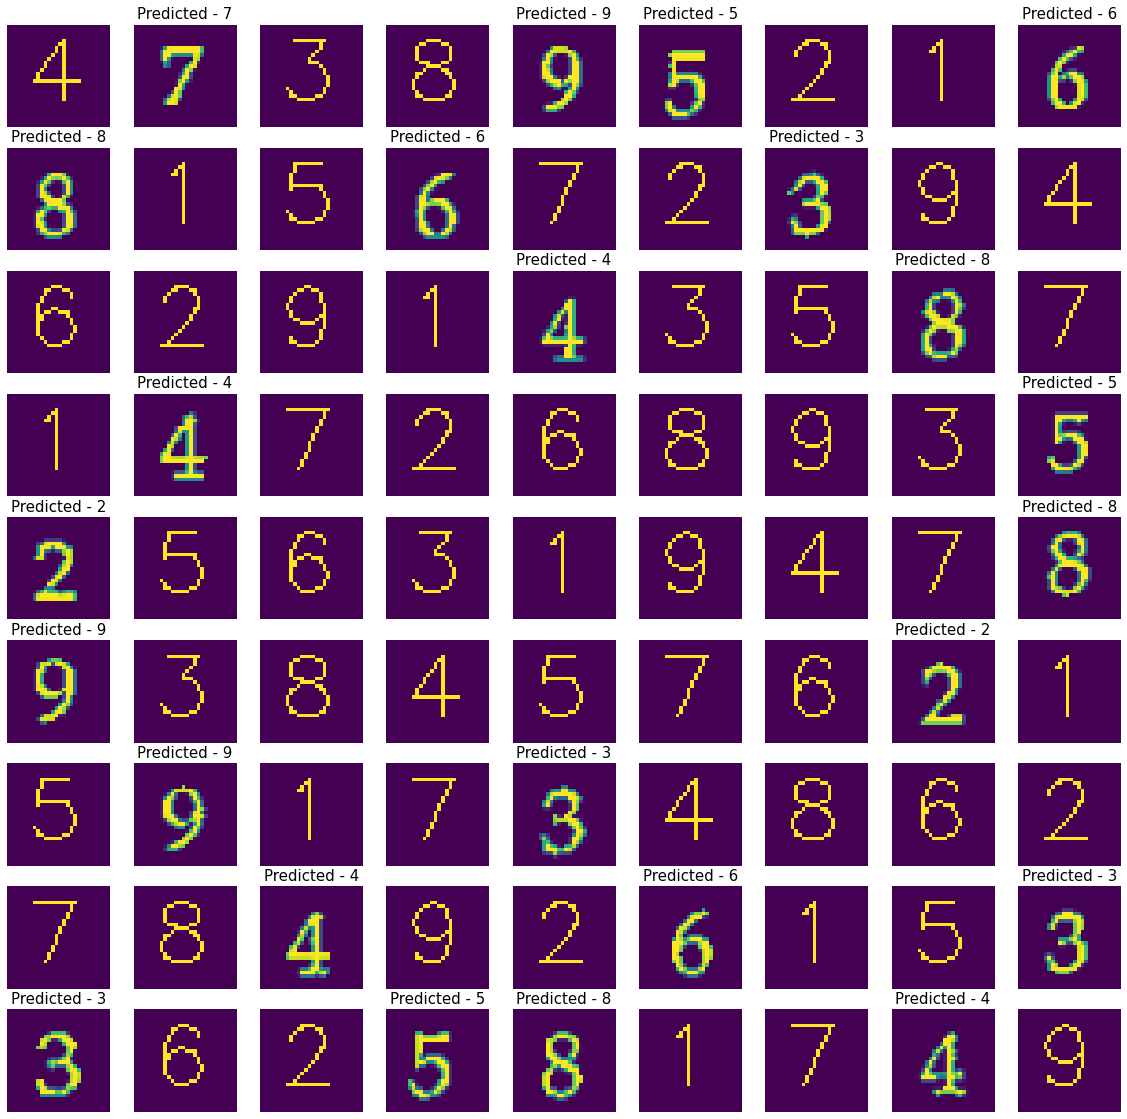

In [87]:
plt.figure(figsize=(20,20))

for idx, box in enumerate(bbox):
    l = grid_solve.reshape(-1)[idx]
    plt.subplot(9,9,idx+1)
    if solution.reshape(-1,1)[idx]!=0:
        img = num_on_img(l)
    else:
        img = img_tile[idx]
        t = f'Predicted - {l}'
        plt.title(t, fontsize=15)
    plt.imshow(img)
    plt.axis('off')